> This notebook is inspired by the [Keras Example](https://github.com/keras-team/keras-io/blob/master/examples/nlp/text_classification_with_transformer.py).

### Part 1: Introduction

#### Exploring Transformers with Keras

Welcome to this Jupyter Notebook, where we will embark on an exciting journey to explore and understand the Transformer architecture using Keras. This notebook is tailored for the Artificial Intelligence course at ESIR – Université Rennes, focusing on practical aspects of implementing and utilizing Transformers in natural language processing (NLP).

#### Background

Transformers, since their introduction in the paper “Attention Is All You Need” by Vaswani et al., have revolutionized the field of NLP. Known for their efficiency in handling sequential data and their ability to capture long-range dependencies, Transformers have set new benchmarks in a wide range of NLP tasks.

In this notebook, we will:

- Implement a Transformer block as a Keras layer.
- Use this Transformer for text classification.
- Compare its performance with a traditional LSTM-based approach.
- Experiment with different hyperparameters to understand their impact.

#### Dataset

We will be working with the Ohsumed dataset, a collection of medical abstracts, which presents a challenging yet insightful task for text classification. This dataset differs from the usual IMDB dataset typically used in transformer examples, providing a more domain-specific challenge.

**Update**: Instead we will be using the IMDB dataset, as it requires less preprocessing and is easier to work with.




### Part 2: Setup and Imports

First, let's set up our environment by importing the necessary libraries. We'll need TensorFlow and its high-level API, Keras, for building and training our models. The layers submodule from Keras provides us with the necessary layers to construct our Transformer model.



In [1]:

# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




TensorFlow will serve as our backend for matrix operations and neural network functionalities, while Keras will offer a user-friendly interface to build and train our models.




### Part 3: Transformer Block Implementation

#### Implementing the Transformer Block

The core of the Transformer model is its unique architecture, which we will implement as a custom layer in Keras. The `TransformerBlock` class encapsulates the key components of the Transformer's architecture.


In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


#### Explanation

This class is a representation of a single Transformer block, which consists of:

1. **Multi-Head Attention Mechanism**: This allows the model to jointly attend to information from different representation subspaces at different positions.

2. **Feed Forward Network**: A simple fully connected neural network applied to each position separately and identically.

3. **Layer Normalization and Dropout**: Used for regularization and to stabilize the training process.

4. **Residual Connections**: Encourage gradient flow through the network.

This block can process a batch of sequences in parallel, making it highly efficient for NLP tasks.



### Part 4: Data Preparation

#### Loading the Dataset



In [3]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)



### Part 5: Model Building

#### Creating the Classifier Model

Now, we will use the previously defined Transformer block to build our classifier model. The model architecture is designed to process the input text, apply the Transformer block, and then classify the text into appropriate categories.



In [6]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [7]:

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)



#### Explanation

In this architecture:

- The `TokenAndPositionEmbedding` layer first processes the input sequences.
- The `TransformerBlock` applies the attention mechanism and feedforward network.
- The `GlobalAveragePooling1D` layer condenses the output from the transformer block.
- The `Dense` layers at the end serve as a classifier on top of the transformer outputs.

### Part 6: Model Compilation

#### Compiling the Model

After building the model, it needs to be compiled with the appropriate loss function and optimizer. Since this is a classification task, we'll use the 'sparse_categorical_crossentropy' loss.



In [11]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [14]:
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_val, y_val))


Epoch 1/5
391/391 [==============================] - 22s 56ms/step - loss: 0.1071 - accuracy: 0.9640 - val_loss: 0.4235 - val_accuracy: 0.8605
Epoch 2/5
391/391 [==============================] - 22s 57ms/step - loss: 0.0716 - accuracy: 0.9784 - val_loss: 0.4915 - val_accuracy: 0.8576
Epoch 3/5
391/391 [==============================] - 23s 59ms/step - loss: 0.0479 - accuracy: 0.9866 - val_loss: 0.6163 - val_accuracy: 0.8458
Epoch 4/5
391/391 [==============================] - 23s 59ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 0.6446 - val_accuracy: 0.8424
Epoch 5/5
391/391 [==============================] - 23s 60ms/step - loss: 0.0316 - accuracy: 0.9916 - val_loss: 0.7246 - val_accuracy: 0.8472


# Ploting

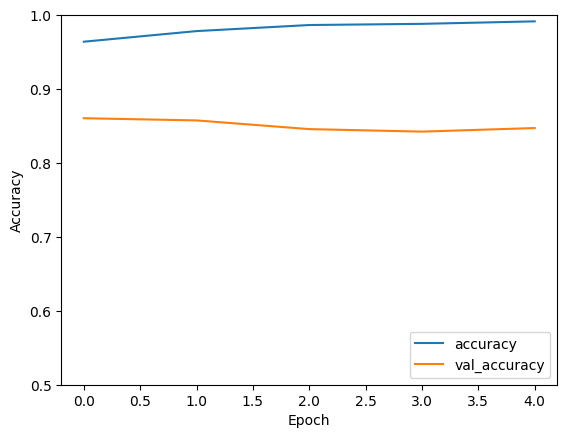

In [15]:
## Plotting 
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

plt.show()

# Compare with the LSTM baseline

![image.png](../../TP1_2/Exercices/exo1.png)

# Conclusion and Further Steps


### Model Comparison: Transformer vs. LSTM

#### LSTM Baseline Performance
- **Convergence Speed**: The LSTM baseline exhibits a slower convergence rate towards achieving optimal accuracy. This can be particularly noticeable in complex tasks or with larger datasets, where the LSTM's recurrent nature might contribute to longer training times.
- **Handling Long Sequences**: Another aspect where LSTM struggles is in processing very long sequences due to its sequential data processing nature, which might lead to issues like vanishing or exploding gradients.

#### Transformer Model Advantages
- **Faster Convergence**: In contrast to the LSTM, the Transformer model demonstrates a faster convergence to high accuracy. This efficiency is primarily due to its parallel processing capabilities and the self-attention mechanism, which allows it to learn dependencies between words irrespective of their position in the sequence.
- **Scalability with Sequence Length**: Unlike LSTMs, Transformers handle long sequences more effectively due to their attention mechanism, which provides a global understanding of the input sequence, leading to better performance in tasks involving longer texts.
- **Better Contextual Understanding**: The self-attention mechanism in Transformers offers a more nuanced understanding of context. It dynamically weighs the significance of different parts of the input data, which can lead to improved performance in tasks like sentiment analysis, where context plays a critical role.
- **Flexibility and Adaptability**: Transformers have shown remarkable adaptability to a variety of tasks beyond text classification, including language translation, summarization, and even non-language tasks. This versatility makes them a valuable tool in the broader field of natural language processing and beyond.

#### Conclusion
While the LSTM provides a robust baseline, the Transformer model clearly demonstrates superior performance in terms of convergence speed, scalability, and contextual understanding, making it a more efficient and versatile choice for advanced text processing tasks.
